In [13]:
import cv2
import os
from google.colab.patches import cv2_imshow  # Importing cv2_imshow function specifically for Google Colab
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive/', force_remount=True)

# Define the path to the input video file
video_path = '/content/drive/MyDrive/perception_hw2_1/proj2_v2.mp4'

# Define the directory to save the output video file
output_directory = '/content/drive/MyDrive/perception_hw2_1'
os.makedirs(output_directory, exist_ok=True)

# Open the video file for reading
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the width and height of the video frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object for writing the output video with fps = 10
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = os.path.join(output_directory, 'output_video.mp4')
out = cv2.VideoWriter(output_video_path, fourcc, 10, (width, height))



Mounted at /content/drive/


In [14]:
import numpy as np

def variance_of_laplacian(image):
    # Define the Laplacian kernel manually
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])

    # Perform convolution with the Laplacian kernel
    laplacian = cv2.filter2D(image, -1, laplacian_kernel)

    # Compute the variance of the Laplacian
    return laplacian.var()


The Laplacian kernel is chosen for its ability to detect edges in images effectively. It highlights regions of rapid intensity change, making it ideal for edge detection tasks. Additionally, its symmetry and simplicity make it a popular choice for image processing algorithms.
The -4 in the center of the kernel indicates that the contribution of the center pixel is negative, while the contributions of its surrounding pixels are positive.





wait.... scanning video...............................


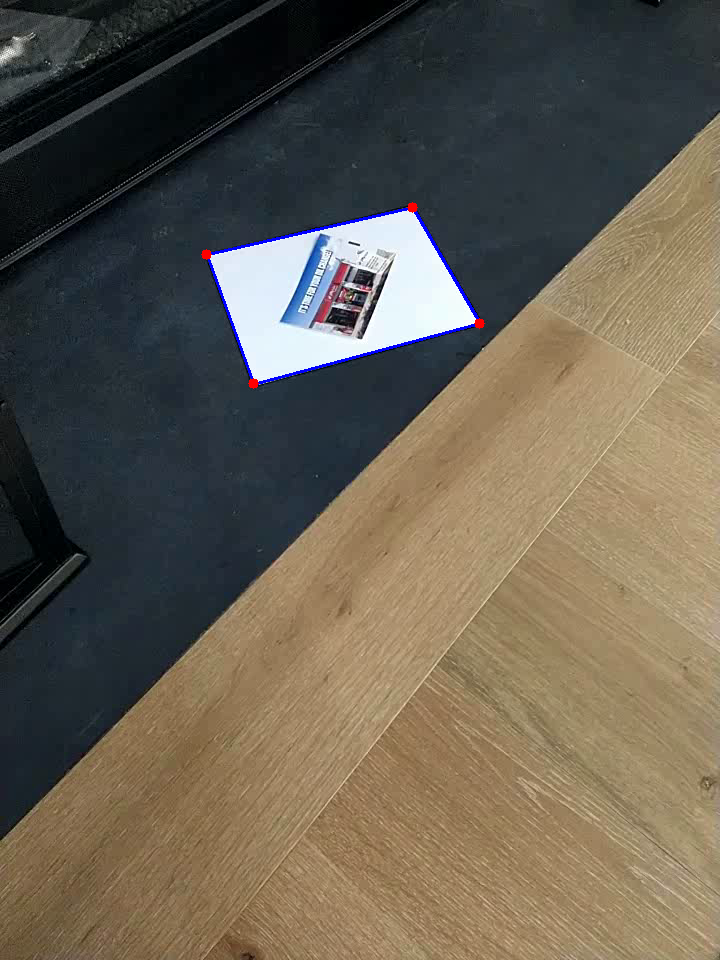

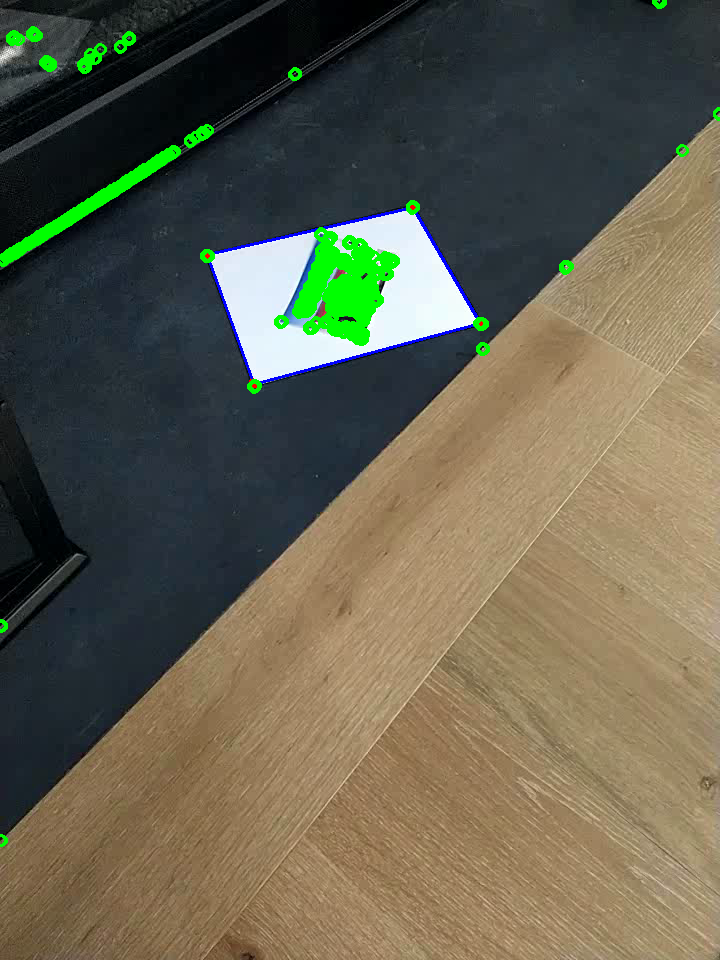

nmber of frames= 386
not blurry frames= 107
removed frames= 279


In [15]:
frame_count =0
not_blurry_frames=0
blockSize = 2  # Size of the neighborhood considered for corner detection
ksize = 3      # Aperture parameter for the Sobel operator (gradient computation)
k = 0.04
print ('wait.... scanning video...............................')
while True:
    intersections = []
    lines_list =[]
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
      break
    frame_path = os.path.join(output_directory, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(frame_path, frame) # split the video into frames and stores in output directory
    frame_count = frame_count+1
    # height, width = frame.shape[:2]
    # print("Height:", height, "pixels")
    # print("Width:", width, "pixels")

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converts frame into gray scale
    # Compute the variance of Laplacian for the grayscale image
    laplacian_var = variance_of_laplacian(gray)
    # print (laplacian_var)
    if laplacian_var > 80:  #sets thersold variance to 80
      not_blurry_frames += 1 #counts not blurry frames
      # Creating a binary mask using np.where
      mask = np.where(gray > 220, 255, 0).astype(np.uint8)
      # Set all pixels below the threshold to white (255)
      white_frame = cv2.bitwise_and(frame, frame, mask=mask)
      # cv2_imshow(white_frame)
      edges = cv2.Canny(white_frame, 100, 200)  #applies the Canny edge detection algorithm to the white_frame image with lower
      # and upper thresholds set to 100 and 200, respectively. This algorithm identifies and highlights edges in the image, with
      # the specific thresholds controlling the sensitivity of the detection. You can adjust the threshold values as needed
      # Display the original frame and the detected edges
      # cv2_imshow(white_frame)
      # cv2_imshow(edges)
      lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=65, minLineLength=100, maxLineGap=10)
      #The line lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=75, minLineLength=100, maxLineGap=10) applies
      # the probabilistic Hough transform algorithm to detect line segments in the edges image. Parameters such as rho, theta,
      # threshold, minLineLength, and maxLineGap control the sensitivity and accuracy of the detection.
      # cv2_imshow(frame)
      # Draw the detected lines on the original frame
      if lines is not None:
          for line in lines:
              # print(line)
              x1, y1, x2, y2 = line[0] #picking up the first line in hough lines
              cv2.line(frame, (x1, y1), (x2, y2), (255,0, 0), 2)
              lines_list.append(line[0]) # draws border lines on the paper in frame
      # cv2_imshow(frame)
      # the below loop finds the intersections of border lines on the paper and appended them in the intersetion list
      for i in range(len(lines_list)):
          for j in range(i+1, len(lines_list)):
              # Get the endpoints of the two lines
              line1 = lines_list[i]
              line2 = lines_list[j]
              x1, y1, x2, y2 = line1  # Endpoints of line1
              x3, y3, x4, y4 = line2  # Endpoints of line2

              # Calculate the denominator for determining the intersection point
              denominator = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))

              # Check if denominator is not zero to avoid division by zero
              if denominator != 0:
                  # Calculate the intersection point coordinates (px, py)
                  px = (((x1*y2 - y1*x2) * (x3 - x4)) - ((x1 - x2) * (x3*y4 - y3*x4))) / denominator
                  py = (((x1*y2 - y1*x2) * (y3 - y4)) - ((y1 - y2) * (x3*y4 - y3*x4))) / denominator

              if 100 <= px <= 800 and 100 <= py <= 600:
                  # intersections.append((px, py))
                  intersections.append([int(px), int(py)])
      # print(intersections)
      for intersection in intersections:
        cv2.circle(frame, tuple(intersection), 5, (0, 0, 255), -1) #shows intersections on the images with red circle of size 5
      out.write(frame)
      if frame_count==1:#showing random frame 2 for found corners in the frame
        cv2_imshow(frame)

      # cv2_imshow(frame) # uncomment this line for visulaizing all the frames with corners
      # plt.imshow(frame) #plots on imgae
      dst = cv2.cornerHarris(gray, blockSize, ksize, k) # This is a varification step for the above intersections
      # The line dst = cv2.cornerHarris(gray, blockSize, ksize, k) in OpenCV applies
      # the Harris corner detection algorithm to the gray image to detect corners. Parameters include blockSize, ksize, and k, which
      #control the neighborhood size, size of the Sobel kernel, and the sensitivity factor, respectively.
      # Define a threshold to determine corners' strength
      threshold = 0.01 * dst.max()

      # Extract corners above the threshold
      corner_indices = np.where(dst > threshold)

      # Draw circles around detected corners on the original frame
      for i in range(len(corner_indices[0])):
          cv2.circle(frame, (corner_indices[1][i], corner_indices[0][i]), 5, (0, 255, 0), 2) #prints circle with blue color on detected corners

      # Display the frame with detected corners
      if frame_count==1: #showing random frame 2 for harris corners
        cv2_imshow(frame)
print ('nmber of frames=', frame_count )
print('not blurry frames=', not_blurry_frames)
print ('removed frames=', (frame_count- not_blurry_frames))
cap.release()
out.release()
# Close all OpenCV windows
cv2.destroyAllWindows()



This code reads a video frame by frame and performs several image processing tasks. It first splits the video into frames and checks for the variance of Laplacian to determine if the frame is blurry. If the frame is sufficiently sharp, it converts it to grayscale, applies edge detection using the Canny algorithm, and then detects lines using the Hough transform. The detected lines are used to find intersections, which are then marked on the original frame. Additionally, the code applies the Harris corner detection algorithm to verify the detected corners. Detected corners are marked on the original frame using the Harris corner detector. Finally, the code writes the processed frames to an output video file. The process is repeated until all frames in the video are processed. The output includes the number of frames processed, the count of non-blurry frames, and the count of removed frames due to blurriness.

the code gives the output of two images one showing the detected corners and other is for validation by using harris corner dectection method. And also gives the final video showing the dectected corners.

here is the link for colab file, you can directlyu click on this to go to my colab : https://colab.research.google.com/drive/1vi8Duh3geTgrZqLPc5pi1nieRSixKl3y?usp=sharing